In [ ]:
# import the necessary libraries
import numpy as np
import scipy as sp
from scipy.io import loadmat
from scipy.integrate import simps
from scipy.ndimage import gaussian_filter
import h5py
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

file_path = '/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/\
My Drive/Pauly Lab/Paper Submissions/Crossbeam/Strain/data/'
figure_path = '/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/\
My Drive/Pauly Lab/Paper Submissions/Crossbeam/Strain/figures/'

### data upload

In [ ]:
# # import the data
# # uncomment this section if you are downloading the data from Google Drive
# !gdown -O Yp 'https://drive.google.com/uc?id=1jv478-btcv7Z6VUqInY3aSSFUq-BVwhy'
# !gdown -O Xp 'https://drive.google.com/uc?id=1jv06SoyNC0fgz3Zp0S7u4nQKaSNkF-hI'
# !gdown -O peak_disp_y 'https://drive.google.com/uc?id=1jv2l_O_d4b1sel_xXytEw7APLz7XyWnC'
# !gdown -O peak_disp_x 'https://drive.google.com/uc?id=1jucUFrTuevvaHCci-nRb12mJvKnN2e4H'


# ax_part_disp = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/Strain/code/Yp', 'r')
# lat_part_disp = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/Strain/code/Xp', 'r')
# peak_ax_disp = loadmat('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/Strain/code/peak_disp_y')
# peak_lat_disp = loadmat('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/Strain/code/peak_disp_x')

In [ ]:
# uncomment this code if you are uploading the data from your local machine
peak_lat_disp = loadmat(file_path + 'peak_disp_x.mat')
peak_ax_disp = loadmat(file_path + 'peak_disp_y.mat')

# get the lateral particle displacement
lat_part_disp = h5py.File(file_path + 'Xp.mat', 'r')

# get the axial particle displacement
ax_part_disp = h5py.File(file_path + 'Yp.mat', 'r')

In [ ]:
# define the data class for easier parsing
class SimSetup:
    def __init__(self, ax_part_disp, lat_part_disp, peak_ax_disp, peak_lat_disp):
        self.ax_part_disp = np.transpose(ax_part_disp['Yp'][()], (2, 1, 0))
        self.lat_part_disp = np.transpose(lat_part_disp['Xp'][()], (2, 1, 0))
        self.peak_ax_disp = peak_ax_disp['peak_disp_yt']
        self.peak_lat_disp = peak_lat_disp['peak_disp_xt']

In [ ]:
trxd = SimSetup(ax_part_disp=ax_part_disp,
                lat_part_disp=lat_part_disp,
                peak_ax_disp=peak_ax_disp,
                peak_lat_disp=peak_lat_disp)

In [ ]:
# simulation parameters
Nx = 300    # grid points
Ny = 300    # grid points
dx = 0.2e-3 # resolution in x [m]
dy = 0.2e-3 # resolution in y [m]

def dynamic_extent(x, y):
    return (x * dx * 1e3, (Nx-x) * dx * 1e3,
            (-Ny + 2 * y) * dy * 1e3 / 2, (Ny - 2 * y) * dy * 1e3 / 2)

### Tissue Displacement due to Acoustic Radiation Force

In [ ]:
tissue_disp_max = max(np.max(trxd.peak_ax_disp), np.max(trxd.peak_lat_disp))
tissue_disp_min = min(np.min(trxd.peak_ax_disp), np.min(trxd.peak_lat_disp))

peak_ax_disp_norm = 2 * (trxd.peak_ax_disp - tissue_disp_min) / (tissue_disp_max -  tissue_disp_min) - 1
peak_lat_disp_norm = 2 * (trxd.peak_lat_disp - tissue_disp_min) / (tissue_disp_max -  tissue_disp_min) - 1

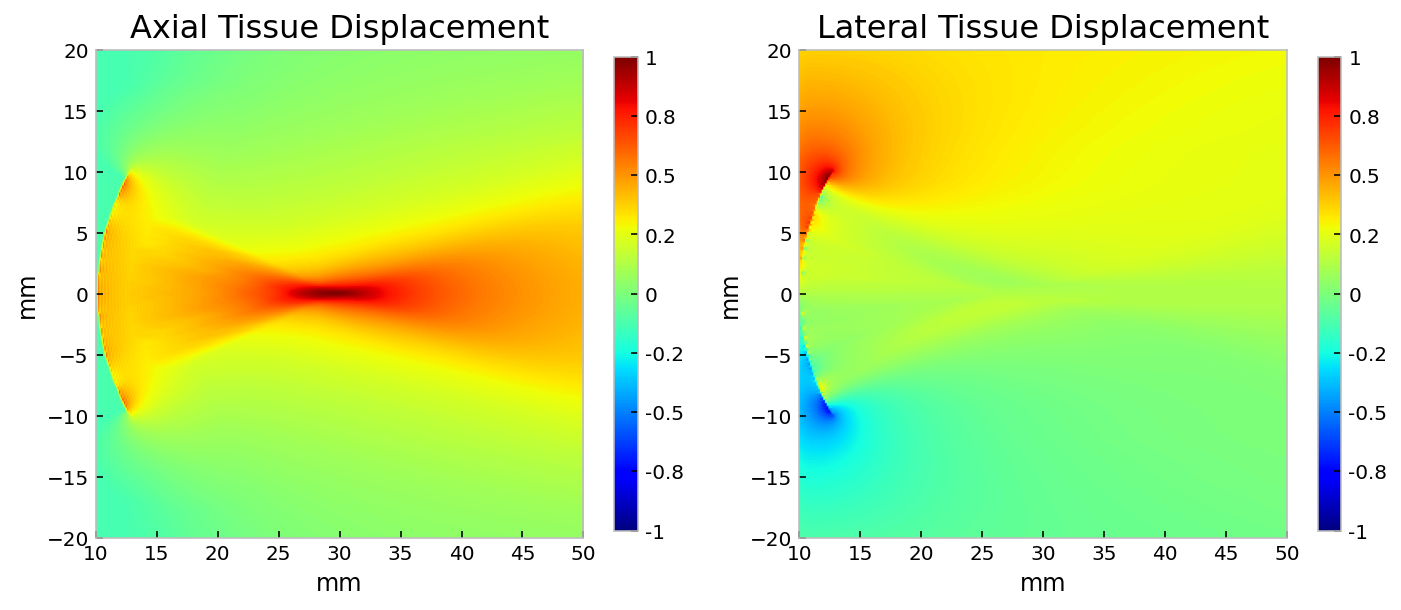

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Axial Tissue Displacement', fontsize=16)
plt.imshow(peak_ax_disp_norm,
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Lateral Tissue Displacement', fontsize=16)
plt.imshow(- peak_lat_disp_norm,
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'tissue_displacement.png', dpi=600)
plt.show()

### Particle Displacement due to Pressure

In [ ]:
part_disp_max = max(np.max(trxd.ax_part_disp), np.max(trxd.lat_part_disp))
part_disp_min = min(np.min(trxd.ax_part_disp), np.min(trxd.lat_part_disp))

ax_part_disp_norm = 2 * (trxd.ax_part_disp - part_disp_min) / (part_disp_max -  part_disp_min) - 1
lat_part_disp_norm = 2 * (trxd.lat_part_disp - part_disp_min) / (part_disp_max -  part_disp_min) - 1

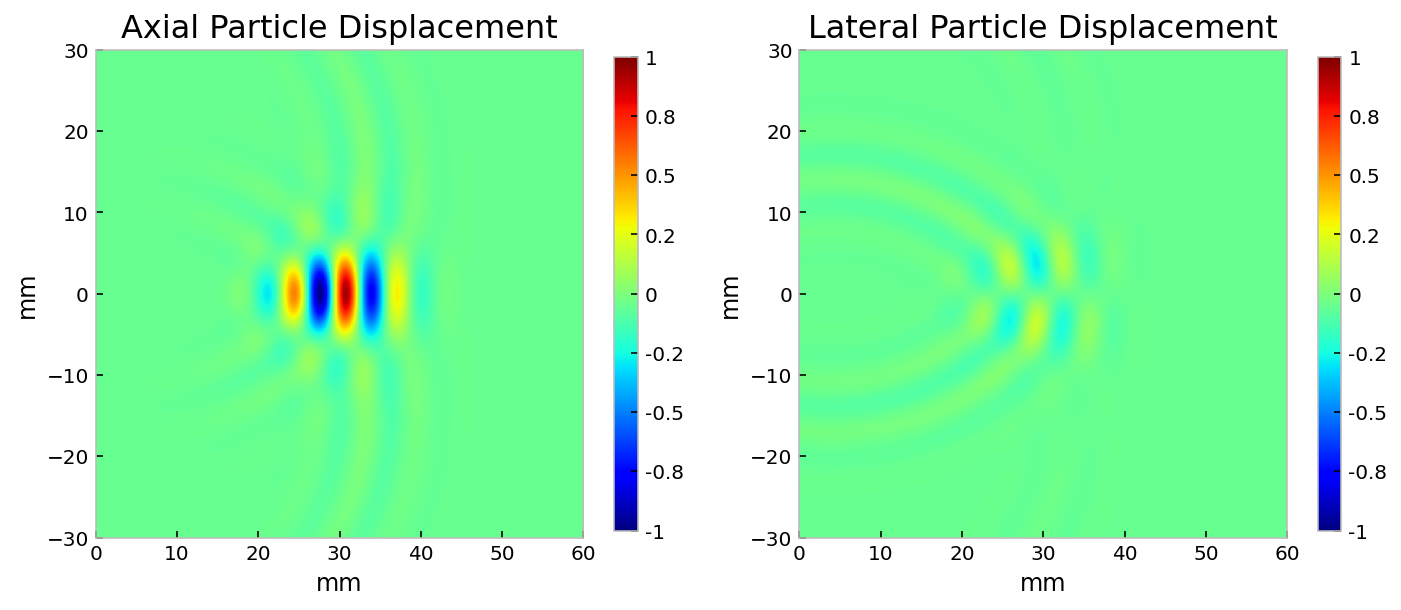

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Axial Particle Displacement', fontsize=16)
plt.imshow(ax_part_disp_norm[:, :, 2300],
           extent=dynamic_extent(0, 0), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Lateral Particle Displacement', fontsize=16)
plt.imshow(lat_part_disp_norm[:, :, 2300],
           extent=dynamic_extent(0, 0), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'particle_displacement.png', dpi=600)
plt.show()

### Strain due to Tissue Displacement ($\mathcal{E}^{ARF}$)
Since tissue displacement is caused by acoustic radiation force, we will denote this strain by $\mathcal{E}^{ARF}$.

In [ ]:
def compute_strain(ax_disp, lat_disp, res):
    e_xx = np.gradient(ax_disp, res, axis=1)
    e_yy = np.gradient(lat_disp, res, axis=0)
    e_xy = 0.5 * (np.gradient(ax_disp, res, axis=0) + np.gradient(lat_disp, res, axis=1))
    e_yx = e_xy

    return e_xx, e_yy, e_xy

In [ ]:
ARF_exx, ARF_eyy, ARF_exy = compute_strain(trxd.peak_ax_disp, - trxd.peak_lat_disp, dx)

In [ ]:
ARF_strain_max = max(np.max(ARF_exx[50:-50, 50:-50]),
                     np.max(ARF_eyy[50:-50, 50:-50]),
                     np.max(ARF_exy[50:-50, 50:-50]))
ARF_strain_min = min(np.min(ARF_exx[50:-50, 50:-50]),
                     np.min(ARF_eyy[50:-50, 50:-50]),
                     np.min(ARF_exy[50:-50, 50:-50]))

ARF_exx_norm = 2 * (ARF_exx - ARF_strain_min) / (ARF_strain_max -  ARF_strain_min) - 1
ARF_eyy_norm = 2 * (ARF_eyy - ARF_strain_min) / (ARF_strain_max -  ARF_strain_min) - 1
ARF_exy_norm = 2 * (ARF_exy - ARF_strain_min) / (ARF_strain_max -  ARF_strain_min) - 1

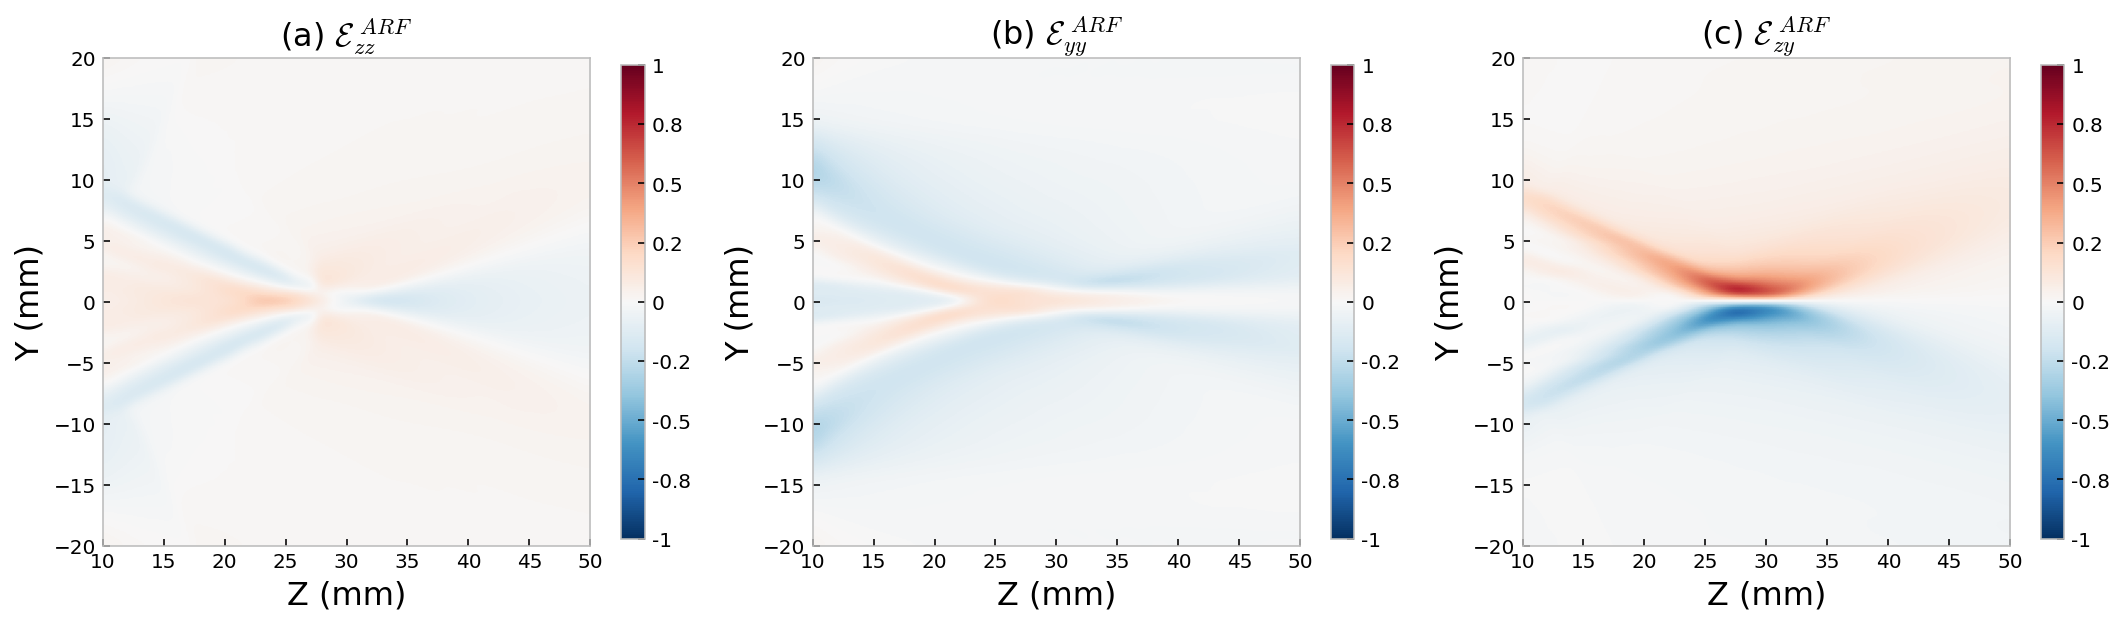

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) $\mathcal{E}^{\ ARF}_{zz}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_exx_norm[50:-50, 50:-50], 2.0),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{yy}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_eyy_norm[50:-50, 50:-50], 2.0),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) $\mathcal{E}^{\ ARF}_{zy}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_exy_norm[50:-50, 50:-50], 2.0),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_strain.png', dpi=600)
plt.show()

### Strain due to Particle Displacement ($\mathcal{E}^{PM}$)
Since particle displacement is caused by instantaneous, periodic particle motion under acoustic pressure, we will denote this strain by $\mathcal{E}^{PM}$.

In [ ]:
PM_exx, PM_eyy, PM_exy = compute_strain(trxd.ax_part_disp[:, :, 2300], - trxd.lat_part_disp[:, :, 2300], dx)

In [ ]:
PM_strain_max = max(np.max(PM_exx[50:-50, 50:-50]),
                     np.max(PM_eyy[50:-50, 50:-50]),
                     np.max(PM_exy[50:-50, 50:-50]))
PM_strain_min = min(np.min(PM_exx[50:-50, 50:-50]),
                     np.min(PM_eyy[50:-50, 50:-50]),
                     np.min(PM_exy[50:-50, 50:-50]))

PM_exx_norm = 2 * (PM_exx - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_eyy_norm = 2 * (PM_eyy - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_exy_norm = 2 * (PM_exy - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1

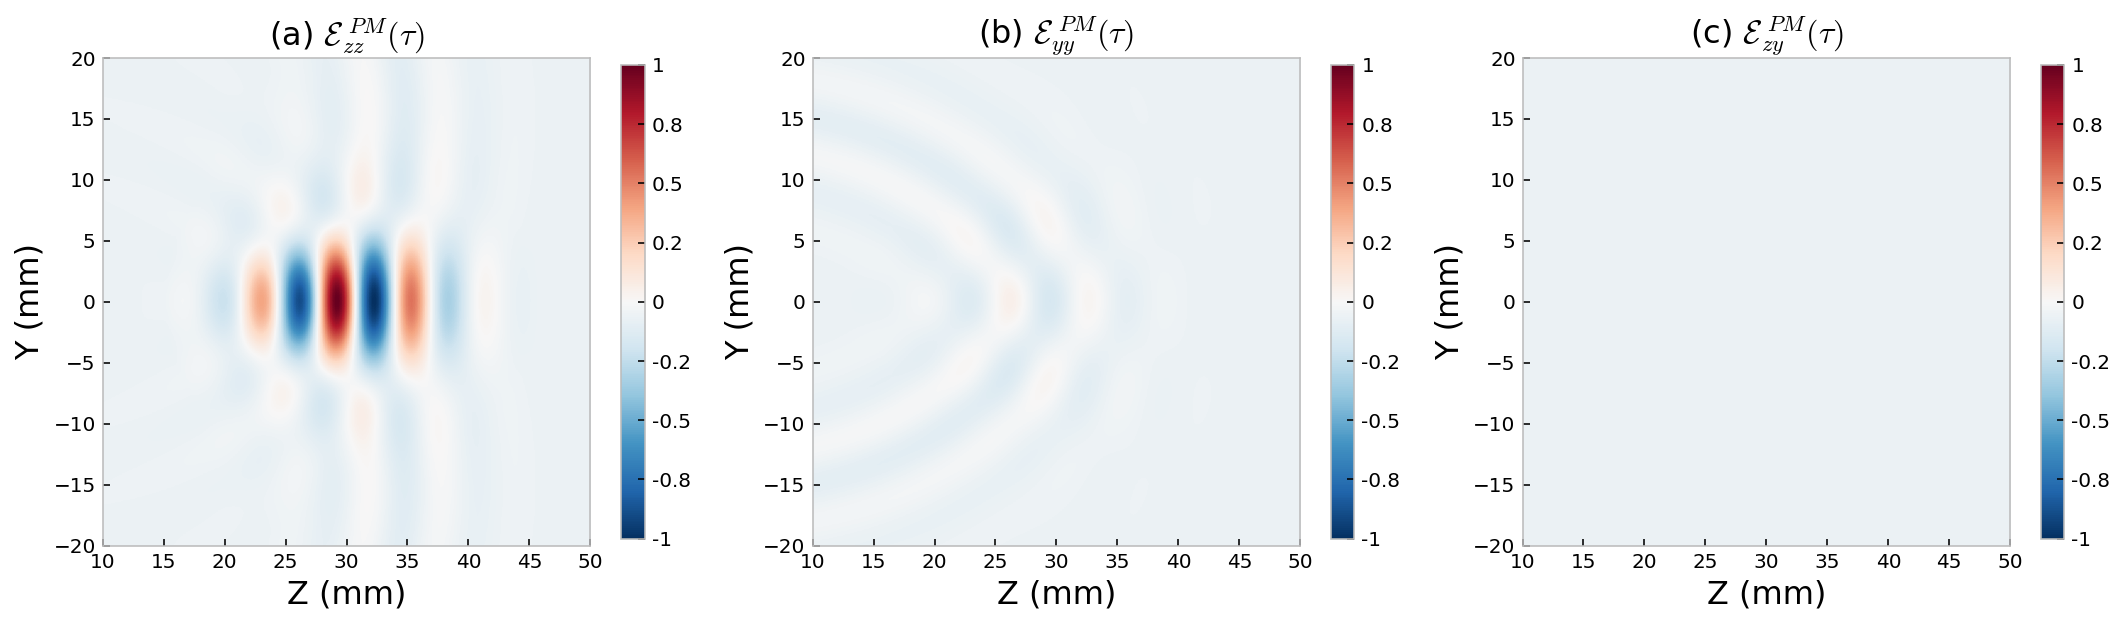

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title(r'(a) $\mathcal{E}^{\ PM}_{zz} (\tau)$', fontsize=16)
plt.imshow(PM_exx_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title(r'(b) $\mathcal{E}^{\ PM}_{yy} (\tau)$', fontsize=16)
plt.imshow(PM_eyy_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title(r'(c) $\mathcal{E}^{\ PM}_{zy} (\tau)$', fontsize=16)
plt.imshow(PM_exy_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'PM_strain.png', dpi=600)
plt.show()

In [ ]:
PM_exx_envelope = np.max(np.gradient(trxd.ax_part_disp[:, :, :], dx, axis=1) , axis=2)

In [ ]:
PM_exx_envelope_norm = (2 * (PM_exx_envelope - PM_strain_min) /
                        (PM_strain_max - PM_strain_min) - 1)

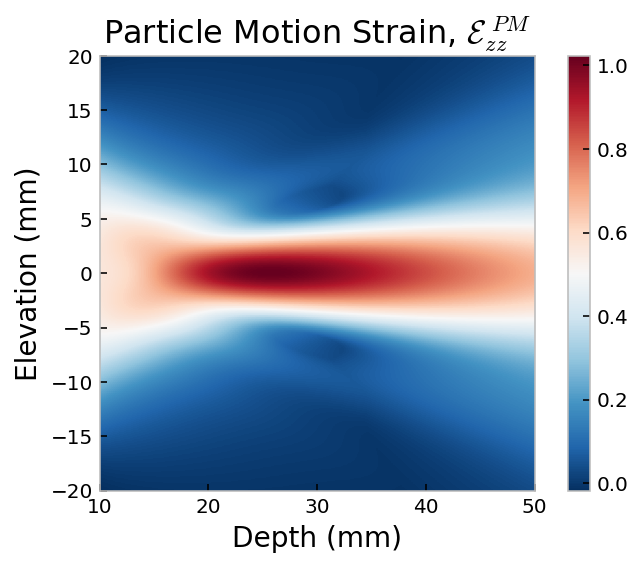

In [ ]:
plt.title('Particle Motion Strain, $\mathcal{E}^{\ PM}_{zz}$', fontsize=16)
plt.imshow(PM_exx_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar()
plt.xlabel('Depth (mm)', fontsize=14)
plt.ylabel('Elevation (mm)', fontsize=14)

#plt.savefig(figure_path + 'PM_strain_max.png', dpi=600)
plt.show()

### Comparing Independently Normalized Strain Fields

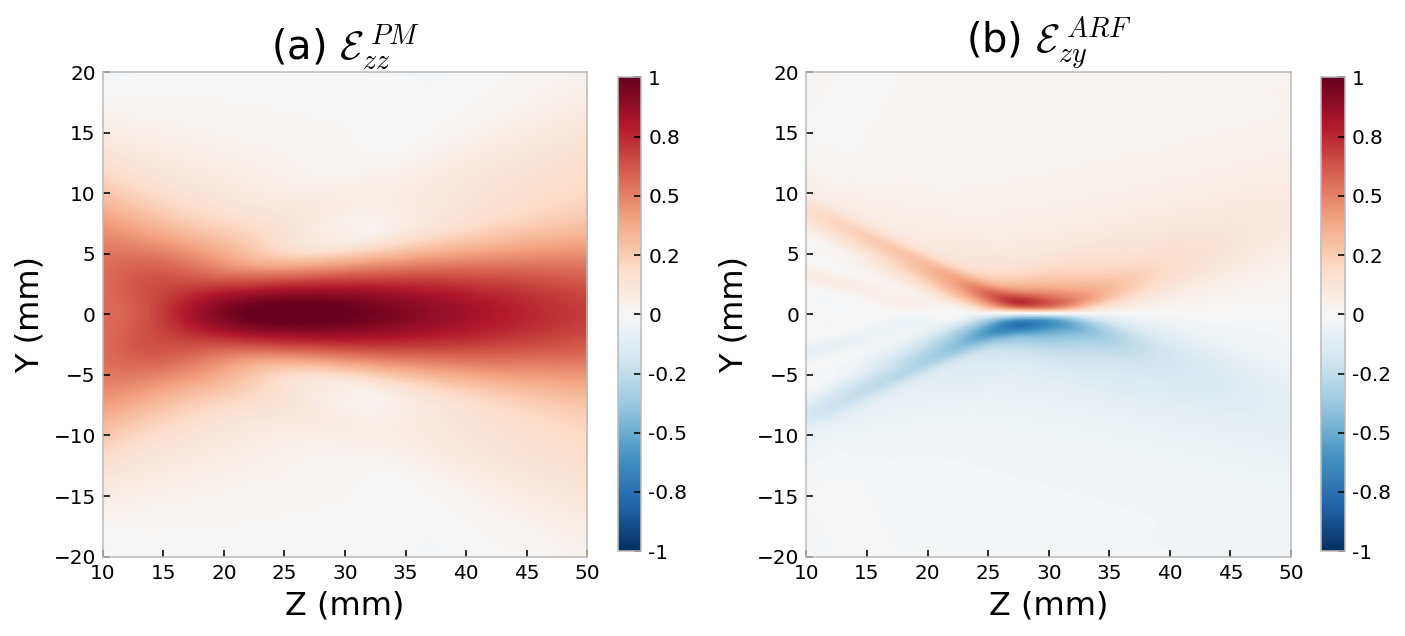

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('(a) $\mathcal{E}^{\ PM}_{zz}$', fontsize=20)
plt.imshow(PM_exx_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)

plt.subplot(1, 2, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{zy}$', fontsize=20)
plt.imshow(gaussian_filter(ARF_exy_norm[50:-50, 50:-50], 2.0),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_PM_strain_comparison.png', dpi=600)
plt.show()